# Conv Denoising Autoencoder

The purpose of this notebook is to demonstrate the use of a convolutional autoencoder for image embeddings. I have added noise to the input in order for the model to generalise better. A possible extension would be other transformations (rotations, flips, filters, cropping) to increase generalisation of embeddings.

## Import Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import cifar100, fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

## Data wrangling and analysis 

In [2]:
train_category_list = os.listdir("/kaggle/input/imagenetmini-1000/imagenet-mini/train")
val_category_list = os.listdir("/kaggle/input/imagenetmini-1000/imagenet-mini/val")


train_filename_list = []
val_filename_list = []

for cat in train_category_list:
    path = "/kaggle/input/imagenetmini-1000/imagenet-mini/train/{}".format(cat)
    file_path = [path + "/{}".format(file) for file in os.listdir(path)]
    train_filename_list.extend(file_path)
    
for cat in val_category_list:
    path = "/kaggle/input/imagenetmini-1000/imagenet-mini/val/{}".format(cat)
    file_path = [path + "/{}".format(file) for file in os.listdir(path)]
    val_filename_list.extend(file_path)

Width: 372 pixels, Height: 500 pixels
Max pixel value: 255.0, Min pixel value: 0.0
Mean pixel value: 124.64596557617188, Standard Deviation: 69.45359802246094


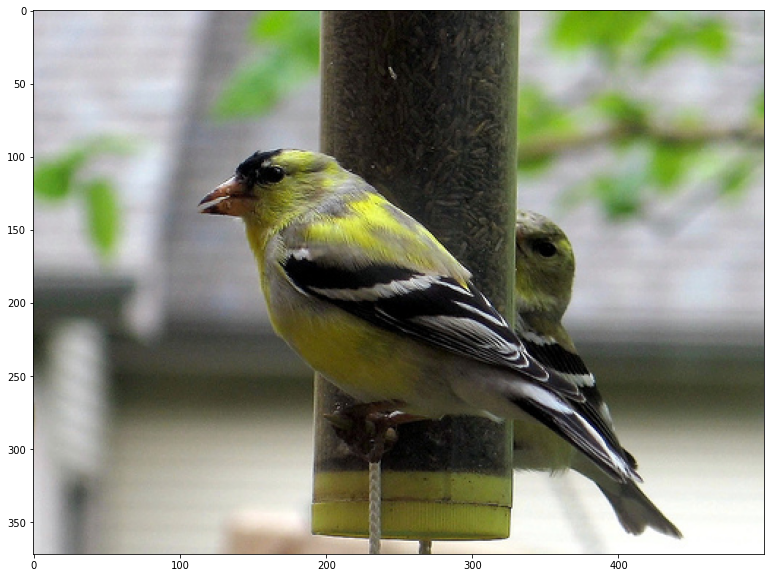

In [3]:
test_image = image.load_img(train_filename_list[0])
img_np = image.img_to_array(test_image)

plt.figure(figsize=(20, 10))
plt.imshow(test_image)

print("Width: {} pixels, Height: {} pixels".format(img_np.shape[0], img_np.shape[1]))
print("Max pixel value: {}, Min pixel value: {}".format(img_np.max(), img_np.min()))
print("Mean pixel value: {}, Standard Deviation: {}".format(img_np.mean(), img_np.std()))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

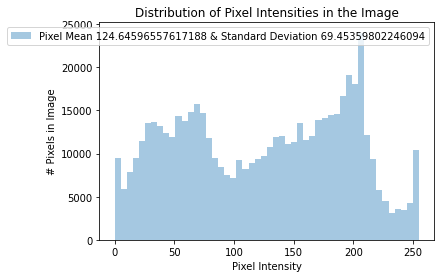

In [4]:
import seaborn as sns

sns.distplot(img_np.ravel(),
             label="Pixel Mean {} & Standard Deviation {}".format(np.mean(img_np),np.std(img_np)), 
             kde=False)
plt.legend(loc='upper right')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [5]:
sample_train_filename_list = random.sample(train_filename_list, 1000)
sample_val_filename_list = random.sample(val_filename_list, 100)

In [6]:
def get_image_data(file_list, size = (128, 128)):
    # iterating through each file
    image_list = []
    for file in file_list:
        
        current_image = image.load_img(file, target_size = size, 
                                       color_mode = 'rgb')
        # covert image to a matrix
        img_array = image.img_to_array(current_image)
        image_list.append(img_array)
    

    image_data = np.stack(image_list, axis=0 )
        
    return image_data

In [7]:
x_train = get_image_data(sample_train_filename_list)
x_val = get_image_data(sample_val_filename_list)

In [8]:
x_val.shape

(100, 128, 128, 3)

## Adding Noise to Data

In [9]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_val_noisy = x_val + noise_factor * tf.random.normal(shape=x_val.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_val_noisy = tf.clip_by_value(x_val_noisy, clip_value_min=0., clip_value_max=1.)

2022-08-28 09:19:44.256509: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


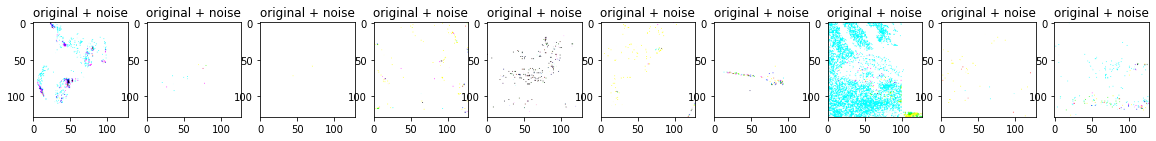

In [10]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_val_noisy[i]))
    plt.gray()
plt.show()

## Building and Running Model

In [11]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(128, 128, 3)),
      layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(1, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(1, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [12]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [13]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_val_noisy, x_val))

2022-08-28 09:19:46.362711: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
32/32 [==============================] - 18s 533ms/step - loss: 18350.1953 - val_loss: 18024.4863
Epoch 2/10
32/32 [==============================] - 16s 492ms/step - loss: 18261.5586 - val_loss: 17959.2520
Epoch 3/10
32/32 [==============================] - 16s 512ms/step - loss: 18246.4883 - val_loss: 17959.2461
Epoch 4/10
32/32 [==============================] - 16s 486ms/step - loss: 18246.4863 - val_loss: 17959.2461
Epoch 5/10
32/32 [==============================] - 16s 515ms/step - loss: 18246.4863 - val_loss: 17959.2441
Epoch 6/10
32/32 [==============================] - 16s 489ms/step - loss: 18246.4844 - val_loss: 17959.2441
Epoch 7/10
32/32 [==============================] - 17s 521ms/step - loss: 18246.4824 - val_loss: 17959.2441
Epoch 8/10
32/32 [==============================] - 16s 487ms/step - loss: 18246.4824 - val_loss: 17959.2422
Epoch 9/10
32/32 [==============================] - 16s 489ms/step - loss: 18246.4785 - val_loss: 17959.2422
Epoch 10/10
32/32 [

## Test Model

In [14]:
image_example = x_train[random.choice(range(len(x_train)))]

In [15]:
image_example = x_train[random.choice(range(len(x_train)))]
image_example = image_example[tf.newaxis,...]
image_example_encoded = autoencoder.encoder.predict(image_example)

In [16]:
image_example_encoded.shape

(1, 8, 8, 1)